In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web

In [40]:
#style.use('ggplot')
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2019, 12, 31)


df = web.DataReader("EQIX", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-10,535.510010,525.380005,535.510010,531.440002,496300.0,531.440002
2019-09-11,533.359985,526.000000,530.190002,528.440002,529900.0,528.440002
2019-09-12,539.679993,528.500000,529.989990,538.880005,435400.0,538.880005
2019-09-13,539.080017,531.789978,537.000000,536.799988,329600.0,536.799988
2019-09-16,551.200012,536.190002,537.739990,549.929993,297300.0,549.929993


In [41]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

mavg.tail(10)

Date
2019-09-03    500.500850
2019-09-04    501.522941
2019-09-05    502.443290
2019-09-06    503.428017
2019-09-09    504.326645
2019-09-10    505.208484
2019-09-11    506.071019
2019-09-12    507.030129
2019-09-13    507.938924
2019-09-16    508.946828
Name: Adj Close, dtype: float64

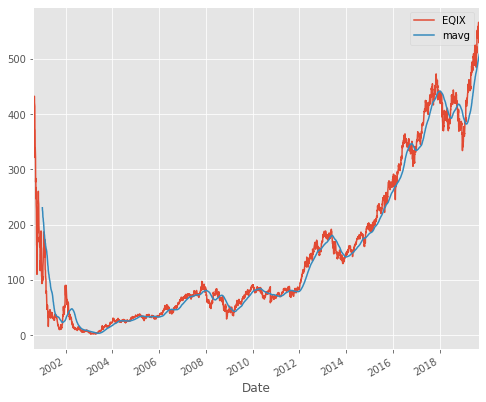

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='EQIX')
mavg.plot(label='mavg')
plt.legend()

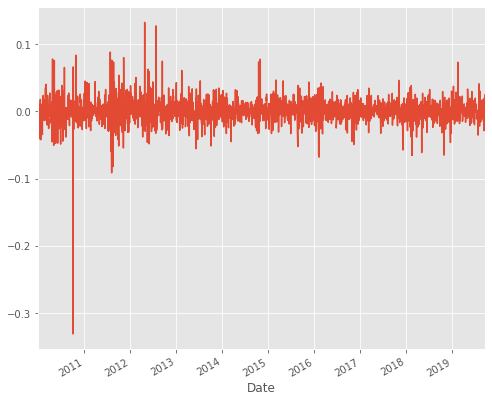

In [29]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [30]:
dfcomp = web.DataReader(['EQIX', 'DLR', 'GOOG'],'yahoo',
                        start=start,end=end)['Adj Close']

In [31]:
dfcomp.head()

Symbols,EQIX,DLR,GOOG
Date,,,
2010-01-04,91.416786,32.631531,312.204773
2010-01-05,90.565681,32.846268,310.829926
2010-01-06,91.391739,32.403797,302.994293
2010-01-07,89.522690,32.690105,295.940735
2010-01-08,89.088821,33.054482,299.885956


In [11]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

Text(0, 0.5, 'Returns DLR')

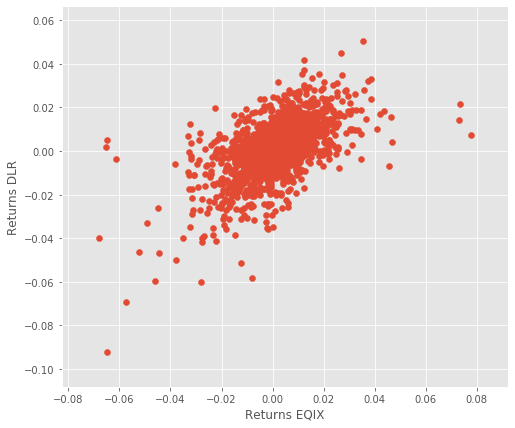

In [12]:
plt.scatter(retscomp.EQIX, retscomp.DLR)
plt.xlabel('Returns EQIX')
plt.ylabel('Returns DLR')

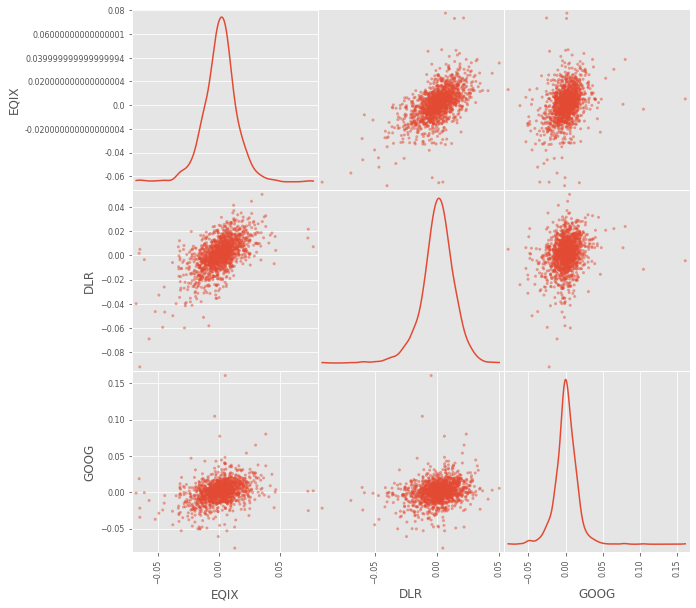

In [13]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

([<matplotlib.axis.YTick at 0x7fd29bf4abe0>,
 <a list of 3 Text yticklabel objects>)

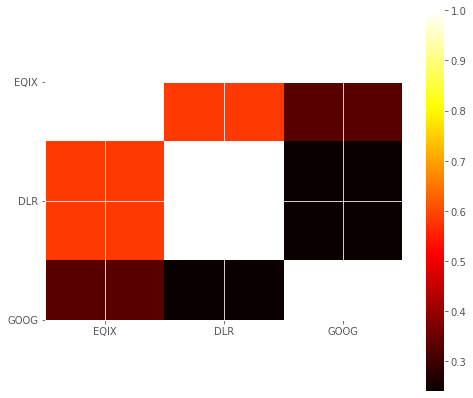

In [14]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

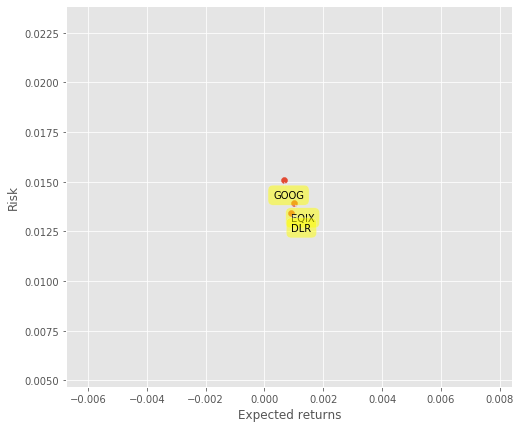

In [15]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

### Predicting Stocks Price

In [43]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2000-08-11,350.447662,792500.0,15.238095,2.941176
2000-08-14,320.409241,80200.0,9.375000,-8.353222
2000-08-15,323.746918,48400.0,3.092784,-0.257069
2000-08-16,330.422089,42100.0,8.080808,2.590674
2000-08-17,320.409241,47200.0,4.687500,-2.040816


### Pre-processing & Cross Validation
    We will clean up and process the data using the following steps before putting them into the prediction models:
- Drop missing value
- Separating the label here, we want to predict the AdjClose
- Scale the X so that everyone can have the same distribution for linear regression
- Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
- Separate label and identify it as y
- Separation of training and testing of model by cross validation train test split

In [44]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution 
# for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X 
# (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

#### Model Generation — Where the prediction fun starts

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
# import counter class from collections module 
from collections import Counter 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.25)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [47]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [48]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print('confidencereg Spread: ',confidencereg)
print('confidencepoly2 Spread: ', confidencepoly2)
print('confidencepoly3 Spread: ', confidencepoly3)
print('confidenceknn Spread: ', confidenceknn)

confidencereg Spread:  0.9625043960137284
confidencepoly2 Spread:  0.9731116732737849
confidencepoly3 Spread:  0.9749022551973778
confidenceknn Spread:  0.9655262431976226


In [49]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan

#### Plotting the Prediction

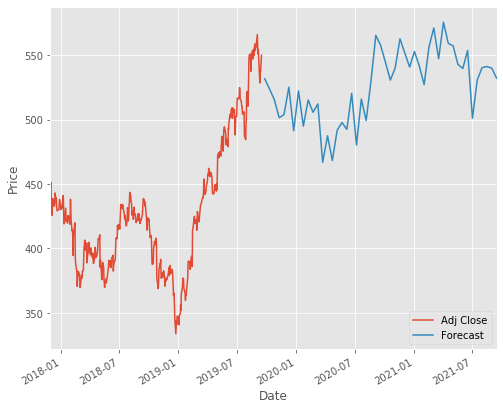

In [50]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + dt.timedelta(days=10)

for i in forecast_set:
    next_date = next_unix
    next_unix += dt.timedelta(days=15)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()